In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [23]:
%%time
JIGSAW_PATH = "../input/"
train = pd.read_csv(os.path.join(JIGSAW_PATH,'train.csv'), index_col='id')
test = pd.read_csv(os.path.join(JIGSAW_PATH,'test.csv'), index_col='id')

/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 15.5 s, sys: 2.69 s, total: 18.2 s
Wall time: 18.2 s


In [24]:
train.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [28]:
train.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,publication_id,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.000000,405130.00000,1.804874e+06,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,0.001410,0.095268,0.127670,0.003237,0.001457,0.025611,0.001088,0.017863,0.006127,0.108687,0.049460,0.001220,0.000884,0.008248,0.006761,0.001494,0.001356,0.012083,0.006724,0.05695,4.986296e+01,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,0.030923,0.256671,0.305384,0.045801,0.030862,0.143739,0.016032,0.122145,0.058684,0.267894,0.202459,0.014102,0.011853,0.042717,0.037504,0.015374,0.017505,0.089183,0.069027,0.21596,2.769869e+01,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000e+00,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.100000e+01,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,5.400000e+01,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,5.400000e+01,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.600000,0.750000,1.000000,1.000000,0.750000,1.000000,1.000000,

In [29]:
print("shape of test - {} and train - {}".format(test.shape, train.shape ))

shape of test - (97320, 1) and train - (1804874, 44)


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


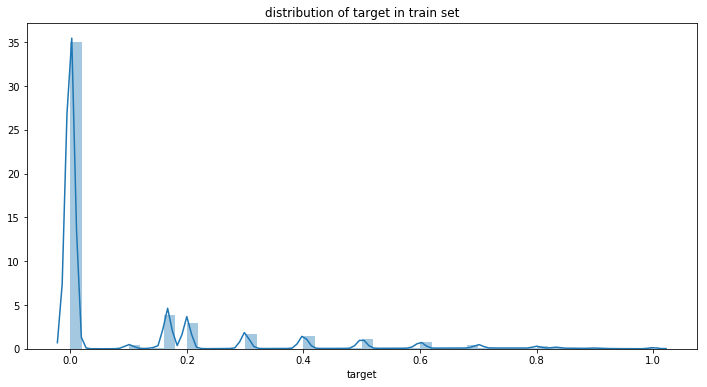

In [30]:
plt.figure(figsize=(12,6))
plt.title("distribution of target in train set")
sns.distplot(train['target'], kde=True,  hist=True, label='Target')
plt.legend; plt.show()

In [33]:
def plot_features_distribution(features, title):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(train[feature],  kde=True,  hist=False, label='Target')
    plt.xlabel('')
    plt.legend()
    plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


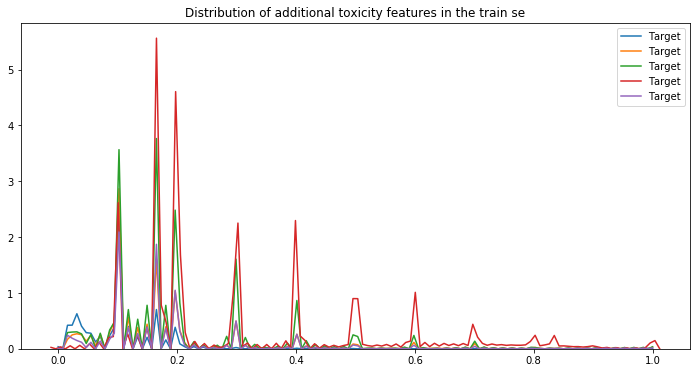

In [34]:
features = ['severe_toxicity', 'obscene','identity_attack','insult','threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train se")

In [38]:
train.groupby(by='rating').count()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
rating,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
approved,1684758,1684758,1684758,1684758,1684758,1684758,1684758,371099,371099,371099,371099,371099,371099,371099,371099,371099,371099,371099,371099,371099,371099,371099,371099,371099,371099,371099,371099,371099,371099,371099,371099,1684758,1684758,958238,1684758,1684758,1684758,1684758,1684758,1684758,1684758,1684758,1684758
rejected,120116,120116,120116,120116,120116,120116,120116,34031,34031,34031,34031,34031,34031,34031,34031,34031,34031,34031,34031,34031,34031,34031,34031,34031,34031,34031,34031,34031,34031,34031,34031,120116,120116,67990,120116,120116,120116,120116,120116,120116,120116,120116,120116


In [39]:
#testing with tfidfvectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

Vectorize = TfidfVectorizer(stop_words='english', token_pattern=r'\w{1,}', max_features=35000)

In [40]:
X = Vectorize.fit_transform(train["comment_text"])
y = np.where(train['target'] >= 0.5, 1, 0)

test_X = Vectorize.transform(test["comment_text"])

In [42]:
X.shape

(1804874, 35000)

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
lr = LogisticRegression(C=32, dual=False, n_jobs=-2, solver='sag')

lr.fit(X_train, y_train)

LogisticRegression(C=32, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-2,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
y_predict=lr.predict(X_test)
print("Model accuracy ", accuracy_score(y_test, y_predict)*100)

Model accuracy  94.60793683773115


In [57]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97    331897
           1       0.74      0.51      0.60     29078

   micro avg       0.95      0.95      0.95    360975
   macro avg       0.85      0.75      0.79    360975
weighted avg       0.94      0.95      0.94    360975



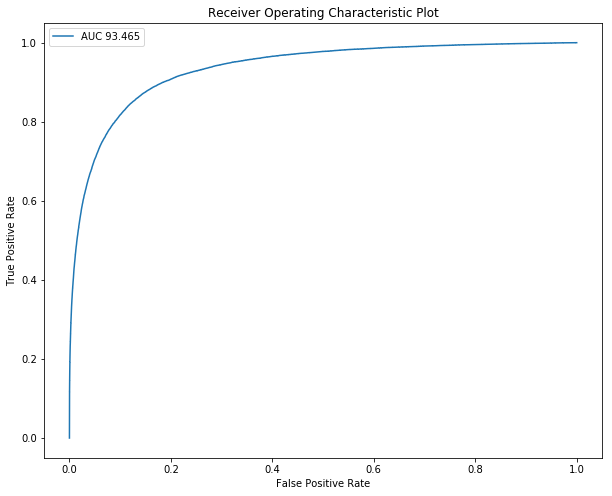

In [58]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thr = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
auc = auc(fpr, tpr) * 100
plt.legend(["AUC {0:.3f}".format(auc)]);

In [59]:
predictions = lr.predict_proba(test_X)

In [61]:
sub = pd.read_csv('../input/sample_submission.csv')

In [62]:
sub['prediction'] = predictions
sub.to_csv('submission.csv', index=False)
sub.head()

,id,prediction
0,7000000,0.987661
1,7000001,0.997493
2,7000002,0.988832
3,7000003,0.997550
4,7000004,0.054338
